In [2]:
process_id = "d8976f98-09d4-44c0-5601-08dc4fa2858c"
page = "1"
url = f"http://ocr.iguidevietnam.com/processes/{process_id}/items?status=done&page={page}&size=10"

import requests
import json
response = requests.get(url).json()
response["items"][0]

{'id': '623dba9d-b89d-4157-3240-08dc4fa285a0',
 'name': '[49A06467-11-00-13-10-2023]_SI4NjPHk6Z39T1xAWvnA_23002426_30_.jpg',
 'type': 'dkx_sau',
 'status': 'done',
 'process': 'd8976f98-09d4-44c0-5601-08dc4fa2858c',
 'image': 'http://ocr.iguidevietnam.com/files/20240329/33d2ce77-958c-4961-9d22-962d90608f01.jpg',
 'itemHistories': [],
 'result': {'doctype': ['vehicle_registration_large_blue_back'],
  'width': 960,
  'height': 1280,
  'textboxes': [{'id': 0,
    'bndbox': [{'x': 692, 'y': 249},
     {'x': 652, 'y': 248},
     {'x': 644, 'y': 784},
     {'x': 683, 'y': 782}],
    'confidence': 1,
    'text': '46 Lý Thường Kiệt P9 Đà Lạt LĐ',
    'label': 'address'},
   {'id': 1,
    'bndbox': [{'x': 653, 'y': 416},
     {'x': 627, 'y': 416},
     {'x': 622, 'y': 702},
     {'x': 648, 'y': 701}],
    'confidence': 1,
    'text': 'TOYOTA',
    'label': 'brand'},
   {'id': 2,
    'bndbox': [{'x': 623, 'y': 928},
     {'x': 592, 'y': 930},
     {'x': 591, 'y': 1130},
     {'x': 621, 'y': 1128

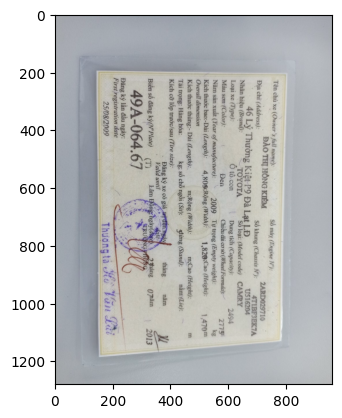

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
result_image_folder = "/home/hung/Downloads/Data OCR/dkx_sau_normalize/images"
result_annotation_folder = "/home/hung/Downloads/Data OCR/dkx_sau_normalize/labels"

image_url = response["items"][0]['image']
img_response = requests.get(image_url)
img_name = image_url.split("/")[-1]

# Convert the image content into a NumPy array
img_array = np.asarray(bytearray(img_response.content), dtype=np.uint8)

# Decode the NumPy array as an image
img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
plt.imshow(img)

(831, 1108)


True

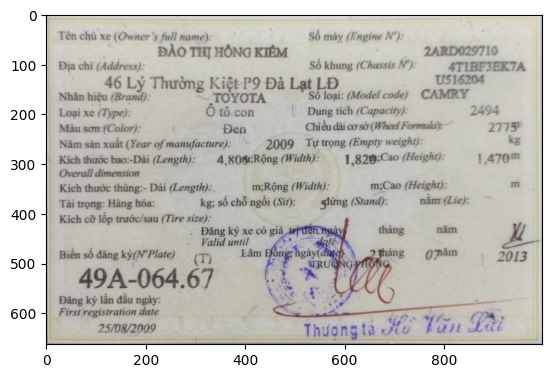

In [4]:
import base64
import numpy as np
from pathlib import Path

homography_obj = response["items"][0]['result']['homographies'][0]
homography = np.frombuffer(base64.b64decode(homography_obj['homo']), dtype=np.float64).reshape(3,3)
width_ratio, height_ratio = homography_obj['width_ratio'], homography_obj['height_ratio']
if width_ratio != 1 or height_ratio != 1:
    height, width = img.shape[:2]
    new_size = (round(width/width_ratio), round(height/height_ratio))
    print(new_size)
    img = cv2.resize(img, new_size)

img = cv2.warpPerspective(img, homography, (homography_obj['width'], homography_obj['height']))
# cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)

plt.imshow(img)
cv2.imwrite(Path(result_image_folder) / img_name, img)



45 115 602 159
[0.045090180360721446, 0.17345399698340874, 0.6032064128256514, 0.2398190045248869] 998 663
normalize_box [45, 173, 603, 239]
216 154 514 182
[0.21643286573146292, 0.23227752639517346, 0.5150300601202404, 0.27450980392156865] 998 663
normalize_box [216, 232, 515, 274]
756 175 975 210
[0.7575150300601202, 0.26395173453996984, 0.9769539078156313, 0.3167420814479638] 998 663
normalize_box [757, 263, 976, 316]
742 86 976 119
[0.7434869739478958, 0.1297134238310709, 0.9779559118236473, 0.1794871794871795] 998 663
normalize_box [743, 129, 977, 179]
608 114 976 146
[0.6092184368737475, 0.17194570135746606, 0.9779559118236473, 0.22021116138763197] 998 663
normalize_box [609, 171, 977, 220]
205 210 496 248
[0.20541082164328658, 0.3167420814479638, 0.4969939879759519, 0.3740573152337858] 998 663
normalize_box [205, 316, 496, 374]
722 22 976 57
[0.7234468937875751, 0.033182503770739065, 0.9779559118236473, 0.08597285067873303] 998 663
normalize_box [723, 33, 977, 85]
608 56 976 88


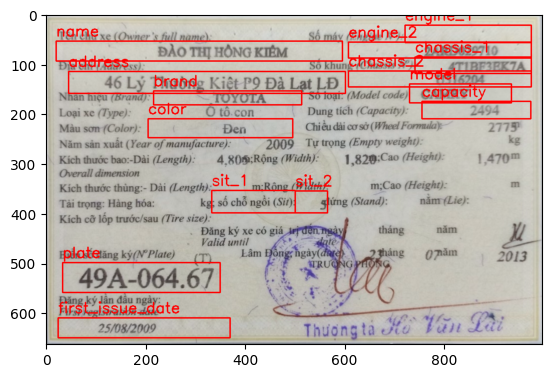

In [9]:
from typing import List, Dict
def pre_process_box(box: List[Dict]):
    new_box = []
    for point in box:
        new_box.append([[point['x'] / width_ratio, point['y'] / height_ratio]])
    four_point_box = np.squeeze(cv2.perspectiveTransform(np.array(new_box, dtype=np.float32), homography))
    x_min = min(four_point_box[:, 0])
    y_min = min(four_point_box[:, 1])
    x_max = max(four_point_box[:, 0])
    y_max = max(four_point_box[:, 1])
    return list(map(float,[x_min, y_min, x_max, y_max]))

def normalize_box(box, image_width, image_height):
    x_min, y_min, x_max, y_max = box
    result = [x_min/image_width, y_min/image_height, x_max/image_width, y_max/image_height]
    print(result, image_width, image_height)
    return list(map(lambda x:int(x*1000), result))

result = []

for box_obj in response["items"][0]['result']['textboxes']:
    bnd_box = box_obj['bndbox']
    text = box_obj['text']
    label = box_obj['label']
    x_min, y_min, x_max, y_max = map(int, pre_process_box(bnd_box))
    print(x_min, y_min, x_max, y_max)
    normalize_boxes = normalize_box([x_min, y_min, x_max, y_max], img.shape[1], img.shape[0])
    print('normalize_box', normalize_boxes)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    cv2.putText(img, f'{label}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    result.append({
        "label": label,
        "text": text,
        "bndbox": normalize_boxes
    })

import json
annotation_file = Path(result_annotation_folder) / f"{Path(img_name).stem}.json"
with open(annotation_file, 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)


plt.imshow(img)

In [17]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv.imread('/home/hung/Pictures/wallpaperflare.com_wallpaper.jpg', cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('/home/hung/Pictures/wallpaperflare.com_wallpaper (1).jpg', cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


In [18]:
import cv2
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
M

array([[-1.07358205e+00, -5.02537008e+00,  2.84777266e+03],
       [-1.30717477e-01, -4.26627134e+00,  1.74721650e+03],
       [-2.43842901e-04, -2.78653074e-03,  1.00000000e+00]])